In [1]:
import numpy as np
from scipy.linalg import inv, eigvals, norm
import matplotlib.pyplot as plt
import cvxpy as cp
from tqdm import tqdm

from utils import *
from models.tvgti_pc_nonsparse import TimeVaryingSEM as TimeVaryingSEM_PC_NONSPARSE
from models.tvgti_pp_nonsparse import TimeVaryingSEM as TimeVaryingSEM_PP_NONSPARSE

In [2]:
def generate_random_S(N, sparsity, max_weight, seed):
    S = np.zeros((N, N))
    
    for i in range(N):
        for j in range(i + 1, N):
            if np.random.rand() < sparsity:
                weight = np.random.uniform(0, max_weight)
                S[i, j] = weight
                S[j, i] = weight
    
    # Ensure spectral radius < 1
    spectral_radius = max(abs(eigvals(S)))
    if spectral_radius >= 1:
        S = S / (spectral_radius + 0.1)
    
    return S

def modify_S(S, edge_indices, factor=2.0):
    S_modified = S.copy()
    for (i, j) in edge_indices:
        if i != j:
            S_modified[i, j] *= factor
            S_modified[j, i] *= factor
    return S_modified

def generate_stationary_X(N, T, sparsity, max_weight, std_e, seed):
    S = generate_random_S(N, sparsity=sparsity, max_weight=max_weight, seed=seed)
    S_series = [S for _ in range(T)]
    e_t_series = np.random.normal(0, std_e, size=(N, T))

    I = np.eye(N)
    try:
        inv_I_S = inv(I - S)
    except np.linalg.LinAlgError:
        raise ValueError("The matrix (I - S) is non-invertible. Please adjust S to ensure invertibility.")

    X = inv_I_S @ e_t_series

    return S_series, X

def generate_stationary_X_from_S(S, N, T, sparsity, max_weight, std_e, seed):
    S = S
    S_series = [S for _ in range(T)]
    e_t_series = np.random.normal(0, std_e, size=(N, T))

    I = np.eye(N)
    try:
        inv_I_S = inv(I - S)
    except np.linalg.LinAlgError:
        raise ValueError("The matrix (I - S) is non-invertible. Please adjust S to ensure invertibility.")

    X = inv_I_S @ e_t_series

    return S_series, X

def generate_piecewise_X(N, T, sparsity, max_weight, std_e, seed):
    seed_0 = seed
    seed_1 = seed + 16
    max_weight_0 = max_weight
    max_weight_1 = max_weight
    S0 = generate_random_S(N, sparsity=sparsity, max_weight=max_weight_0, seed=seed_0)
    S1 = generate_random_S(N, sparsity=sparsity, max_weight=max_weight_1, seed=seed_1)
    S_series = [S0 for _ in range(T // 2)] + [S1 for _ in range(T - T // 2)]
    e_t_series = np.random.normal(0, std_e, size=(N, T))

    I = np.eye(N)
    try:
        inv_I_S0 = inv(I - S0)
        inv_I_S1 = inv(I - S1)
    except np.linalg.LinAlgError:
        raise ValueError("The matrix (I - S) is non-invertible. Please adjust S to ensure invertibility.")

    X0 = inv_I_S0 @ e_t_series[:, :T // 2]
    X1 = inv_I_S1 @ e_t_series[:, T // 2:]
    X = np.concatenate([X0, X1], axis=1)

    return S_series, X

def solve_offline_sem(X_up_to_t, lambda_reg):
    N, t = X_up_to_t.shape
    S = cp.Variable((N, N), symmetric=True)
    
    # objective = (1/(2*t)) * cp.norm(X_up_to_t - S @ X_up_to_t, 'fro') + lambda_reg * cp.norm1(S)
    objective = (1/(2*t)) * cp.norm(X_up_to_t - S @ X_up_to_t, 'fro')
    
    constraints = [cp.diag(S) == 0]
    
    prob = cp.Problem(cp.Minimize(objective), constraints)
    
    prob.solve(solver=cp.SCS, verbose=False)
    
    if prob.status not in ["optimal", "optimal_inaccurate"]:
        raise ValueError("CVXPY did not find an optimal solution.")
    
    S_opt = S.value
    return S_opt

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


100%|██████████| 5000/5000 [00:00<00:00, 34752.59it/s]


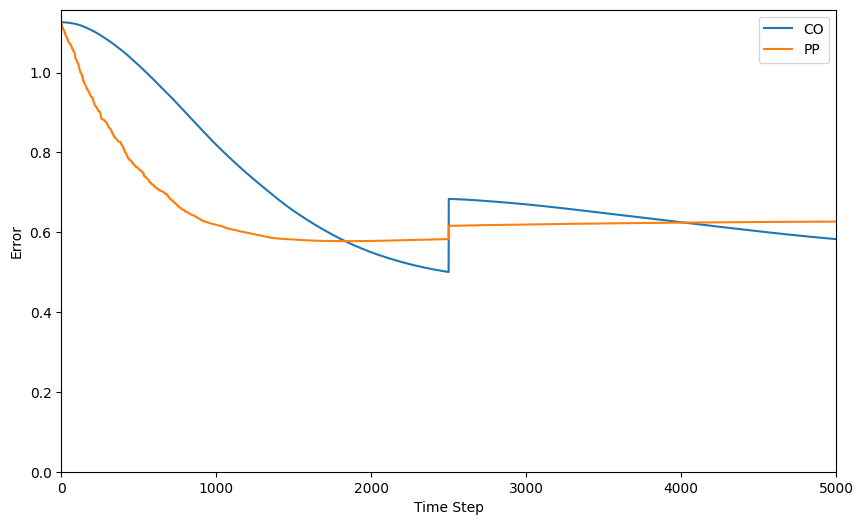

In [3]:
N = 10
T = 5000
sparsity = 100
max_weight = 0.5
change_time = T // 2
variance_e = 0.01
std_e = np.sqrt(variance_e)

seed = 400
np.random.seed(seed)

# TV-SEMシミュレーション
# S_series, X = generate_stationary_X(N=N, T=T, sparsity=sparsity, max_weight=max_weight,
#                                     std_e=std_e, seed=seed)
S_series, X = generate_piecewise_X(N=N, T=T, sparsity=sparsity, max_weight=max_weight,
                                    std_e=std_e, seed=seed)

# オンラインTV-SEMパラメータ
P = 0
C = 1
lambda_reg = 0
# gamma = 0.999
gamma = 0.999
alpha = 0.01
# beta = 1e-7
beta_pc = 1e-4
beta_pp = 1e-5

tv_sem_pc = TimeVaryingSEM_PC_NONSPARSE(N, lambda_reg, alpha, beta_pc, gamma, P, C)
tv_sem_pp = TimeVaryingSEM_PP_NONSPARSE(N, lambda_reg, alpha, beta_pp, gamma, P, C)
estimates_pc = tv_sem_pc.run(X)
estimates_pp = tv_sem_pp.run(X)

NSE = []
error_opt = []
error_pc = []
error_pp = []

# for i in tqdm(range(T)):
#     S_opt = solve_offline_sem(X[:, :i+1], lambda_reg)
#     error_opt.append(norm(S_opt - S_series[i]))

for i, estimate in enumerate(estimates_pc):
    # S_opt = solve_offline_sem(X[:, :i+1], lambda_reg)
    # NSE.append(norm(estimate - S_opt) / norm(S_opt))
    error_pc.append(norm(estimate - S_series[i]))

for i, estimate in enumerate(estimates_pp):
    error_pp.append(norm(estimate - S_series[i]))

# NSEの時間推移をプロット
plt.figure(figsize=(10,6))
# plt.plot(error_opt, label='OPT')
plt.plot(error_pc, label='CO')
plt.plot(error_pp, label='PP')
plt.xlim(0, T)
plt.ylim(0)
plt.xlabel('Time Step')
plt.ylabel('Error')
# plt.title(' between Online TV-SEM and Offline SEM Solutions')
plt.legend()
plt.show()

In [4]:
S_series[0]

array([[0.        , 0.04553618, 0.05851115, 0.00242762, 0.08154983,
        0.10855929, 0.07571065, 0.03078261, 0.00713763, 0.12853551],
       [0.04553618, 0.        , 0.19534608, 0.13886814, 0.08676557,
        0.15994119, 0.02062736, 0.02814077, 0.18999399, 0.11461305],
       [0.05851115, 0.19534608, 0.        , 0.20094926, 0.16205452,
        0.12232696, 0.19249945, 0.07084957, 0.13487162, 0.12464176],
       [0.00242762, 0.13886814, 0.20094926, 0.        , 0.01044979,
        0.04030535, 0.15188988, 0.02824729, 0.19113135, 0.12687722],
       [0.08154983, 0.08676557, 0.16205452, 0.01044979, 0.        ,
        0.11251092, 0.1671097 , 0.00464337, 0.13745913, 0.17819363],
       [0.10855929, 0.15994119, 0.12232696, 0.04030535, 0.11251092,
        0.        , 0.13381341, 0.18781621, 0.03289083, 0.15394247],
       [0.07571065, 0.02062736, 0.19249945, 0.15188988, 0.1671097 ,
        0.13381341, 0.        , 0.05183685, 0.11070614, 0.02486893],
       [0.03078261, 0.02814077, 0.0708495

In [5]:
S_series[-1]

array([[0.        , 0.02292938, 0.05554933, 0.12088347, 0.10672864,
        0.22118943, 0.15777899, 0.17388707, 0.11909639, 0.05508255],
       [0.02292938, 0.        , 0.02091158, 0.1327778 , 0.0349965 ,
        0.12853947, 0.13737834, 0.18552022, 0.06874627, 0.01404226],
       [0.05554933, 0.02091158, 0.        , 0.08685473, 0.08385348,
        0.2207169 , 0.08274671, 0.16401725, 0.18475165, 0.2225803 ],
       [0.12088347, 0.1327778 , 0.08685473, 0.        , 0.09316618,
        0.1808812 , 0.04750697, 0.01917616, 0.0480792 , 0.00955879],
       [0.10672864, 0.0349965 , 0.08385348, 0.09316618, 0.        ,
        0.08565256, 0.01843413, 0.05246056, 0.04936196, 0.14651808],
       [0.22118943, 0.12853947, 0.2207169 , 0.1808812 , 0.08565256,
        0.        , 0.01387898, 0.18477719, 0.04725459, 0.09866187],
       [0.15777899, 0.13737834, 0.08274671, 0.04750697, 0.01843413,
        0.01387898, 0.        , 0.03945628, 0.15033718, 0.08256134],
       [0.17388707, 0.18552022, 0.1640172

Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


100%|██████████| 5000/5000 [00:00<00:00, 43847.42it/s]


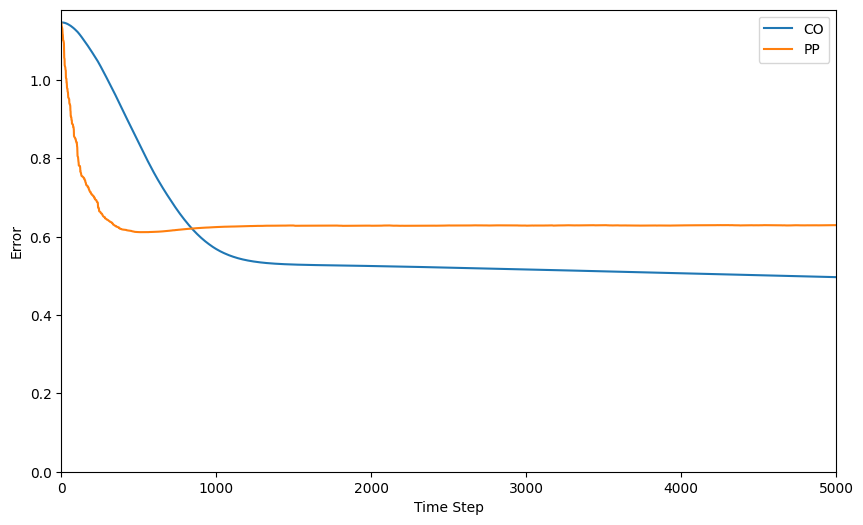

In [6]:
N = 10
T = 5000
sparsity = 100
max_weight = 0.5
change_time = T // 2
variance_e = 0.5
std_e = np.sqrt(variance_e)

seed = 46
np.random.seed(seed)

# TV-SEMシミュレーション
# S_series, X = generate_stationary_X(N=N, T=T, sparsity=sparsity, max_weight=max_weight,
#                                     std_e=std_e, seed=seed)
S_series, X = generate_stationary_X_from_S(S_series[-1], N=N, T=T, sparsity=sparsity, max_weight=max_weight,
                                           std_e=std_e, seed=seed)

# オンラインTV-SEMパラメータ
P = 0
C = 1
lambda_reg = 0
# gamma = 0.999
gamma = 0.999
alpha = 0.01
beta = 1e-7
beta_pc = 1e-5
beta_pp = 1e-6

tv_sem_pc = TimeVaryingSEM_PC_NONSPARSE(N, lambda_reg, alpha, beta_pc, gamma, P, C)
tv_sem_pp = TimeVaryingSEM_PP_NONSPARSE(N, lambda_reg, alpha, beta_pp, gamma, P, C)
estimates_pc = tv_sem_pc.run(X)
estimates_pp = tv_sem_pp.run(X)

NSE = []
error_opt = []
error_pc = []
error_pp = []

# for i in tqdm(range(T)):
#     S_opt = solve_offline_sem(X[:, :i+1], lambda_reg)
#     error_opt.append(norm(S_opt - S_series[i]))

for i, estimate in enumerate(estimates_pc):
    # S_opt = solve_offline_sem(X[:, :i+1], lambda_reg)
    # NSE.append(norm(estimate - S_opt) / norm(S_opt))
    error_pc.append(norm(estimate - S_series[i]))

for i, estimate in enumerate(estimates_pp):
    error_pp.append(norm(estimate - S_series[i]))

# NSEの時間推移をプロット
plt.figure(figsize=(10,6))
# plt.plot(error_opt, label='OPT')
plt.plot(error_pc, label='CO')
plt.plot(error_pp, label='PP')
plt.xlim(0, T)
plt.ylim(0)
plt.xlabel('Time Step')
plt.ylabel('Error')
# plt.title(' between Online TV-SEM and Offline SEM Solutions')
plt.legend()
plt.show()